# Exploring Why Civil Resistance Works

Panagiotis-Alexios Spanakis (t8200158)

### Before we start our analysis, we need to download (if we don't have them already) and import the libraries we will use in this notebook.

We will use the following libraries:

* `pandas` for data manipulation and analysis
* `numpy` for mathematical operations
* `matplotlib` and `seaborn` for data visualization
* `statsmodels`, `sklearn`, `scipy` and `mlxtend` for statistical analysis
* `xlrd` for reading `.xls` files
* `prettytable` for printing tables in a nice format

These libraries can be installed from the command line with the command `pip install <library_name>`.

> **Note:** We created the p5v2018.csv from the command `polity.to_csv('p5v2018.csv')`, where the library xlrd was needed, 
> so the reading of the file would be faster

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from scipy.stats import skew
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import matplotlib.pyplot as plt
from prettytable import PrettyTable

### Then, we need to load the data we will use.

Let's now proceed to load the data we will use in this notebook.

In [3]:
# Load the full navco dataset for the analysis of the Greek campaigns 
navco_full = pd.read_csv('data/NAVCO 1.2 Updated.tab', sep='\t')

# Load the navco dataset for the most of the analysis (we will use only a few columns) for convenience
navco = pd.read_csv('data/NAVCO 1.2 Updated.tab', sep='\t', 
                    usecols=['EYEAR','LOCATION','TARGET','PARTICIPATION',       
                     'PERCENTAGEPOPULARPARTICIPATION','SUCCESS',
                     'FAILURE','LIMITED','NONVIOL','VIOL'
                    ])

Let's see how the navco data look like.

In [4]:
navco.head()

,LOCATION,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,NONVIOL,VIOL,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION
0,Afghanistan,1979.0,Afghan government,1.0,0.0,0.0,0.0,1.0,10000.0,0.000641
1,Afghanistan,1989.0,Soviet occupation,1.0,0.0,0.0,0.0,1.0,10000.0,0.000685
2,Afghanistan,1996.0,Afghan regime,1.0,0.0,0.0,0.0,1.0,20000.0,0.000893
3,Afghanistan,2014.0,Afghan government,0.0,0.0,1.0,0.0,1.0,60000.0,0.001625
4,Albania,1991.0,Communist regime,1.0,0.0,0.0,1.0,0.0,300000.0,0.091068


Now, we will load the polity data. However, we will only load the data after the year 1945, as we will not need the data before that year, because they do not crosscheck with the navco data.

In [5]:
# Load the polity data (we load the full dataset because we will need it for the analysis of the Greek campaigns)
polity = pd.read_csv('data/p5v2018.csv')
# Filter the polity data to include only years after 1945
polity = polity[polity['year'] > 1945]

> **Note**: We now read the full dataset because we will need it for the analysis of the Greek campaigns,
> but later we will get only the columns we need for the analysis.

Let's see how the polity data look like.

In [6]:
polity.head()

,p5,cyear,ccode,scode,country,year,flag,fragment,democ,autoc,...,interim,bmonth,bday,byear,bprec,post,change,d5,sf,regtrans
146,0,7001946,700,AFG,Afghanistan,1946,0,NaN,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,0,7001947,700,AFG,Afghanistan,1947,0,NaN,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,0,7001948,700,AFG,Afghanistan,1948,0,NaN,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,0,7001949,700,AFG,Afghanistan,1949,0,NaN,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,0,7001950,700,AFG,Afghanistan,1950,0,NaN,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that both files have a lot of columns, we will only use a few of them for the statistical analysis. However, we will use all of them for the data interpretation, 
so we will keep them in the dataframes for now.

### Disclaimer
> For the summary statistics at the regression analysis, we will use the `summary2` function from the `statsmodels` library, as because it offers more detailed information than the `summary` function.

## 1. Exploration of Historical Trends

We will create a plot showing the frequency of nonviolent and violent campaigns; the frequency should be counted based on their end years, at decades. The violent and nonviolent campaign counts should be stacked on each other.

We will start by creating a new dataframe that will contain the columns we need from the navco dataset.


Let's firstly set the style of our graphs.

In [7]:
sns.set_style('whitegrid')

In [8]:
# Use of copy to avoid warnings
# Filter the navco dataframe to include only rows with non-null and integer values in the 'EYEAR' column
navco_data_filtered = navco[navco['EYEAR'].notna() & navco['EYEAR'].apply(lambda x: x.is_integer())].copy()

# Create a new column 'Decade' by rounding down the 'EYEAR' values to the nearest decade
navco_data_filtered['Decade'] = (navco_data_filtered['EYEAR'] // 10 * 10).astype(int)

# Create a new column 'Campaign_Type' and set it to 'Violent' for rows where 'NONVIOL' is not equal to 1, otherwise set it to 'Nonviolent'
navco_data_filtered['Campaign_Type'] = 'Violent'
navco_data_filtered.loc[navco_data_filtered['NONVIOL'] == 1, 'Campaign_Type'] = 'Nonviolent'

Now that we have initialised the necessary data, we can start with the plotting.

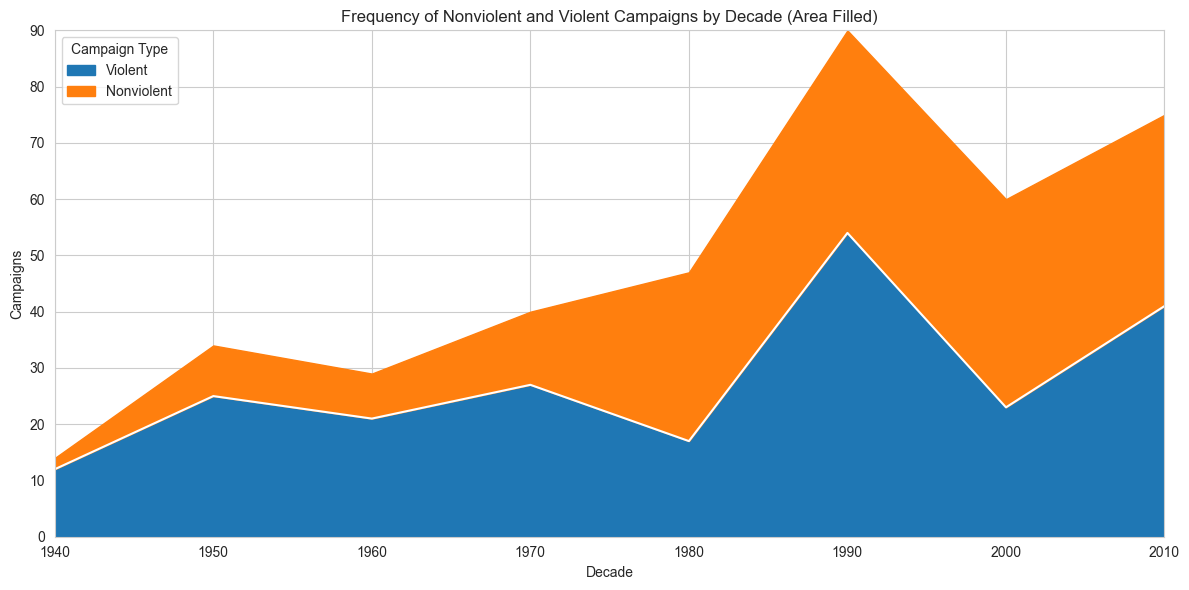

In [9]:
# Group the filtered data by 'Decade' and 'Campaign_Type' and count the occurrences of each combination
decade_campaign_counts = navco_data_filtered.groupby(['Decade', 'Campaign_Type']).size().unstack(fill_value=0)

# Plotting with areas filled under the lines
plt.figure(figsize=(12, 6))

# Calculate the cumulative count of campaigns by adding the counts of 'Violent' and 'Nonviolent' campaigns
cumulative_count = decade_campaign_counts['Violent'] + decade_campaign_counts['Nonviolent']

# Make the line in the 'Violent' campaign line white to make the orange line more visible
plt.plot(decade_campaign_counts.index, decade_campaign_counts['Violent'], color='white')

# Fill the area under the 'Violent' campaign line with blue color
plt.fill_between(decade_campaign_counts.index, 0, decade_campaign_counts['Violent'],
                 color='#1f77b4', alpha=1, label='Violent')

# Fill the area between the 'Violent' and 'Nonviolent' campaign lines with orange color
plt.fill_between(decade_campaign_counts.index, decade_campaign_counts['Violent'], cumulative_count,
                 color='#ff7f0e', alpha=1, label='Nonviolent')
# Remove the margins to remove the extra space
plt.margins(0, 0)
# Set the title, x-axis label, y-axis label, x-ticks, legend, and grid for the plot
plt.title('Frequency of Nonviolent and Violent Campaigns by Decade (Area Filled)')
plt.xlabel('Decade')
plt.ylabel('Campaigns')
plt.xticks(decade_campaign_counts.index)
plt.legend(title='Campaign Type', loc='upper left')

plt.grid(True)
# Set the grid behind the lines
plt.gca().set_axisbelow(True)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

From this plot, we can see that the number of nonviolent campaigns has increased over time along with the number of violent campaigns. Both types of campaigns have increased in number over time, but the increase in the number of nonviolent campaigns is more significant than of the past, showing that nonviolent campaigns have become more popular over time.

We will create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success. The plot will have two vertical axes, one for each of the metrics

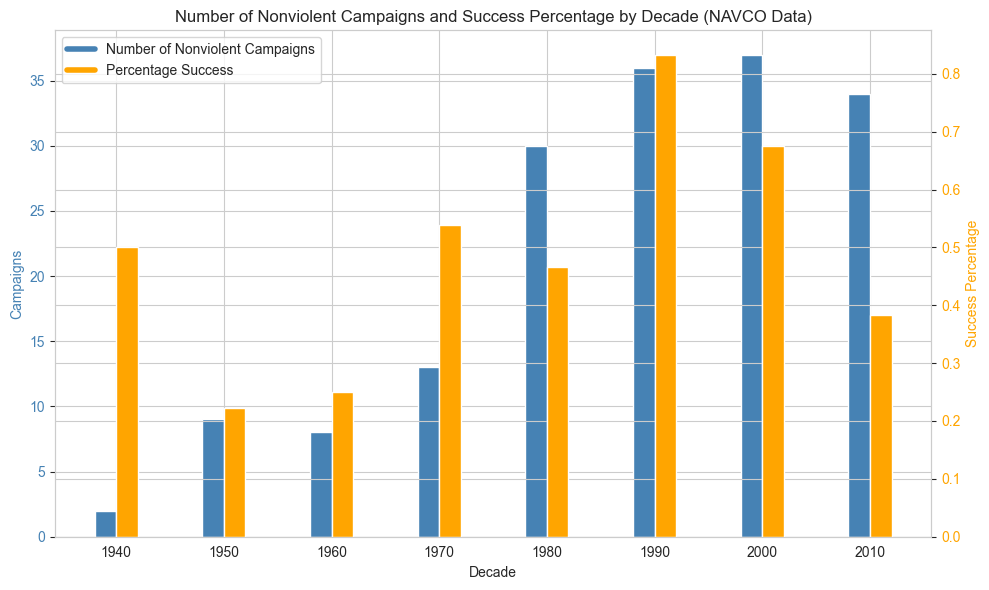

In [10]:
# We filter the navco data to include only nonviolent campaigns with a start year greater than or equal to 1940
navco_data_filtered = navco[(navco['NONVIOL'] == 1) & (navco['EYEAR'] >= 1940)]
# We get the decade of the campaign start year and count the number of campaigns in each decade
decade_counts = navco_data_filtered.groupby(navco_data_filtered['EYEAR'] // 10 * 10).size()
# We also get the success rate of the campaigns in each decade
success_rates = navco_data_filtered.groupby(navco_data_filtered['EYEAR'] // 10 * 10)['SUCCESS'].mean()

# Creating the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# For the number of nonviolent campaigns
color_campaigns = '#4682b4'
ax1.set_xlabel('Decade')
ax1.set_ylabel('Campaigns', color=color_campaigns)
campaigns_bar = ax1.bar(decade_counts.index - 1, decade_counts.values, width=2, color=color_campaigns,
                        label='Nonviolent Campaigns')
ax1.tick_params(axis='y', labelcolor=color_campaigns)

# For the success rates of the campaigns
ax2 = ax1.twinx()
color_success = 'orange'
ax2.set_ylabel('Success Percentage', color=color_success)
success_bar = ax2.bar(success_rates.index + 1, success_rates.values, width=2, color=color_success,
                      label='Success Percentage')
ax2.tick_params(axis='y', labelcolor=color_success)

# Title and layout
plt.title('Number of Nonviolent Campaigns and Success Percentage by Decade (NAVCO Data)')

# Adding legend
# You need to create a combined legend manually since the bars are in different axes
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=color_campaigns, lw=4, label='Number of Nonviolent Campaigns'),
                   Line2D([0], [0], color=color_success, lw=4, label='Percentage Success')]
plt.legend(handles=legend_elements, loc='upper left')
fig.tight_layout()
# Set grid behind the bars
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()


From this graph, we can see that the number of nonviolent campaigns has overall increased over time. We can also see that the percentage of success for nonviolent campaigns has increased over time, with a few exceptions.
 We can also see that the percentage of success is generally higher than the percentage of failure, which is a good sign for nonviolent campaigns.

We will create a plot showing the success rate for violent and nonviolent campaigns by decade. The plot should look like the following, showing that nonviolent campaigns have higher success probabilities:

In [11]:
# Filtering for campaigns for the 'EYEAR' column that are not null and are integers
navco_data_decade_filtered = navco[navco['EYEAR'].notna() & navco['EYEAR'].apply(lambda x: x.is_integer())].copy()
# Creating a new column 'Decade' by rounding down the 'EYEAR' values to the nearest decade
navco_data_decade_filtered['Decade'] = (navco_data_decade_filtered['EYEAR'] // 10 * 10).astype(int)

# Calculating success rates for violent and nonviolent campaigns per decade
success_rates_nonviolent = navco_data_decade_filtered[navco_data_decade_filtered['NONVIOL'] == 1].groupby('Decade')[
                               'SUCCESS'].mean() * 100
success_rates_violent = navco_data_decade_filtered[navco_data_decade_filtered['VIOL'] == 1].groupby('Decade')[
                            'SUCCESS'].mean() * 100

Now that we have prepared success_rates for violent and nonviolent campaigns per decade, we can start with the plotting.

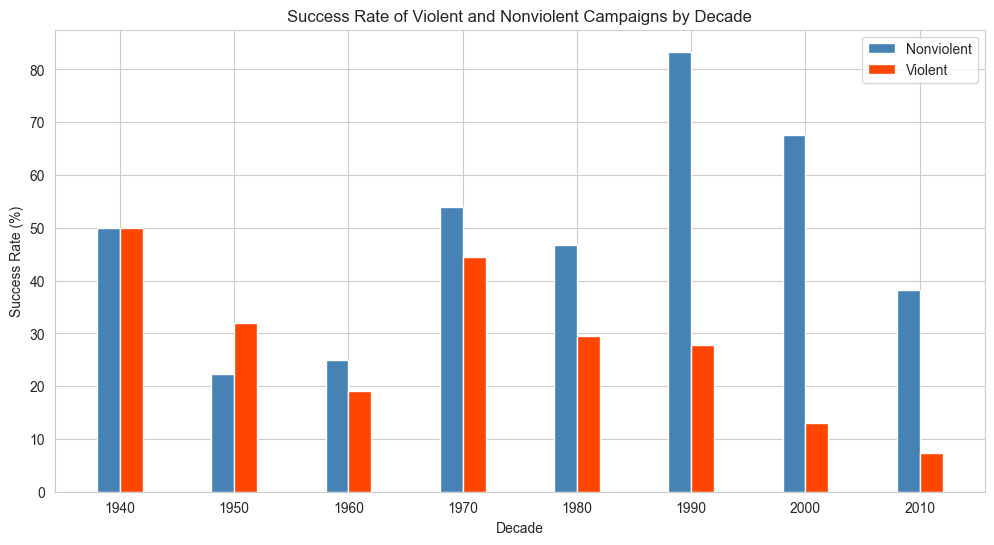

In [12]:
# Creating the plot
plt.figure(figsize=(12, 6))

# Setting the positions for the bars on the x-axis
bar_width = 2
# Adjusting bar positions to have no gap
positions_nonviolent = [decade - bar_width / 2 for decade in success_rates_nonviolent.index]
positions_violent = [decade + bar_width / 2 for decade in success_rates_violent.index]

# Plotting histograms
plt.bar(positions_nonviolent, success_rates_nonviolent.values, width=bar_width, color='#4682b4', label='Nonviolent')
plt.bar(positions_violent, success_rates_violent.values, width=bar_width, color='orangered', label='Violent')
# Setting the remaining plot elements
plt.title('Success Rate of Violent and Nonviolent Campaigns by Decade')
plt.xlabel('Decade')
plt.ylabel('Success Rate (%)')
plt.legend()
# Set the grid behind the bars
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

From this graph it is evident that nonviolent campaigns have a higher success rate than violent campaigns. We can also see that the success rate of nonviolent campaigns has increased over time, while the success rate of violent campaigns has decreased over time. This is a very interesting observation, as it shows that nonviolent campaigns have a higher success rate than violent campaigns and that nonviolent campaigns are more likely to be successful than violent campaigns.

## 2. Largest Resistance Campaigns, 1946-2014

We will create a horizontal bar plot with the resistance campaigns, for all years, with a percentage of participation at least 2.0%.

We will then investigate, outside the largest resistance campaigns, if we can find anything about Greece.


In [13]:
# Create a horizontal bar plot with the resistance campaigns, for all years, with a percentage of participation at least 2.0%. The plot should look like the one below.

# Filter for large campaigns and sort in ascending order of participation percentage
large_campaigns = navco[navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02].copy()  # 2.0% threshold
large_campaigns['PERCENTAGEPOPULARPARTICIPATION'] *= 100  # Convert to percentage
large_campaigns_sorted_desc = large_campaigns.sort_values(by='PERCENTAGEPOPULARPARTICIPATION',
                                                          ascending=True)  # Sort in ascending order


# Assign colors based on the campaign outcome
def assign_color(row):
    if row['SUCCESS'] == 1:
        return 'black'  # Black for success
    elif row['LIMITED'] == 1:
        return 'grey'  # Grey for major concessions
    else:
        return 'red'  # Red for failure


# Create a new column 'Color' and assign colors to each row
large_campaigns_sorted_desc['Color'] = large_campaigns_sorted_desc.apply(assign_color, axis=1)

# Combine country and campaign name for the label
large_campaigns_sorted_desc['Label'] = large_campaigns_sorted_desc['LOCATION'] + ": " + large_campaigns_sorted_desc[
    'TARGET']

Now that we have initialised the necessary data, we can start with the plotting.

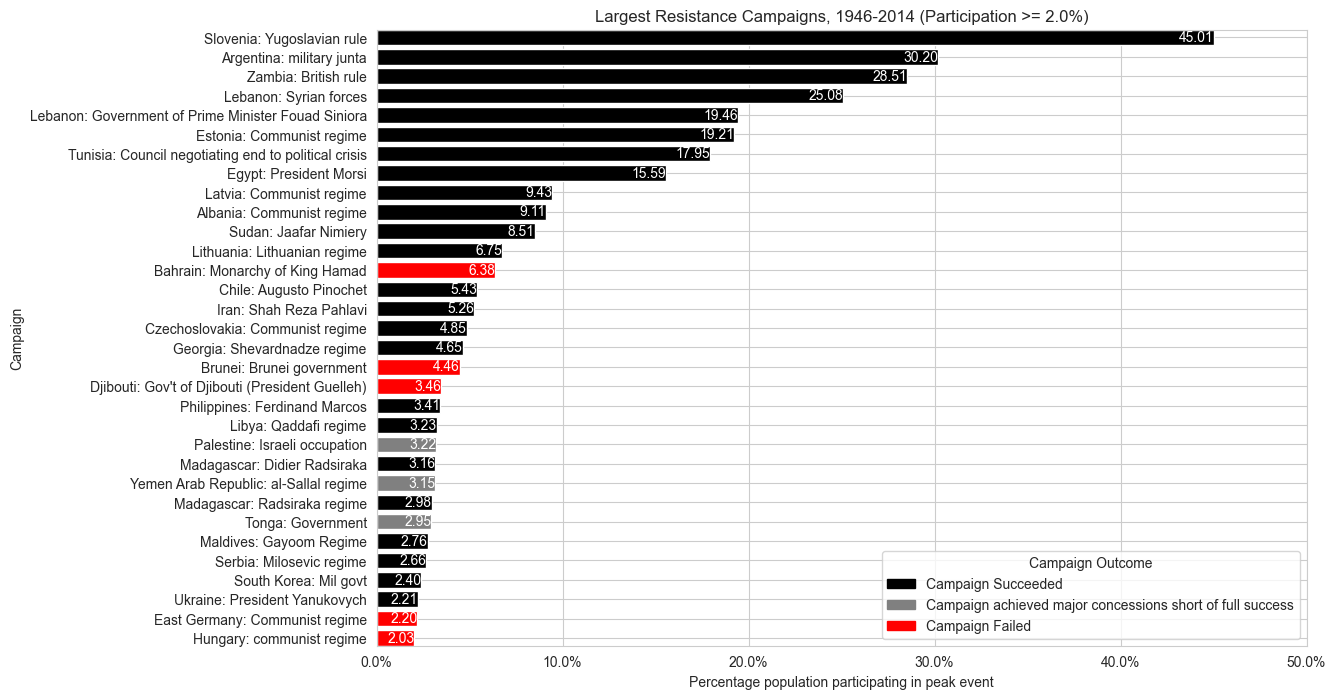

In [14]:
# Creating the horizontal bar plot with assigned colors and displaying percentages
plt.figure(figsize=(12, 8))
bars = plt.barh(large_campaigns_sorted_desc['Label'], large_campaigns_sorted_desc['PERCENTAGEPOPULARPARTICIPATION'],
                color=large_campaigns_sorted_desc['Color'])

# Add the percentages at the end of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='right', color='white')

# Adding a legend for color meanings
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in ['black', 'grey', 'red']],
           labels=['Campaign Succeeded', 'Campaign achieved major concessions short of full success', 'Campaign Failed'],
           title="Campaign Outcome")
# Setting the margins to 0 to remove the extra space
plt.margins(0, 0)
# Setting the remaining plot elements
plt.xlabel('Percentage population participating in peak event')
plt.xlim(0, 50)
# Setting the x-ticks to show percentages
plt.xticks([0, 10, 20, 30, 40, 50], ['0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%'])
plt.ylabel('Campaign')
plt.title('Largest Resistance Campaigns, 1946-2014 (Participation >= 2.0%)')
plt.grid(True)
# Set the grid behind the bars
plt.gca().set_axisbelow(True)
plt.show()

It is evident that most of the largest resistance campaigns have been successful, especially the ones with the highest participation percentage.
Let's check also if these campaigns have been violent or nonviolent.

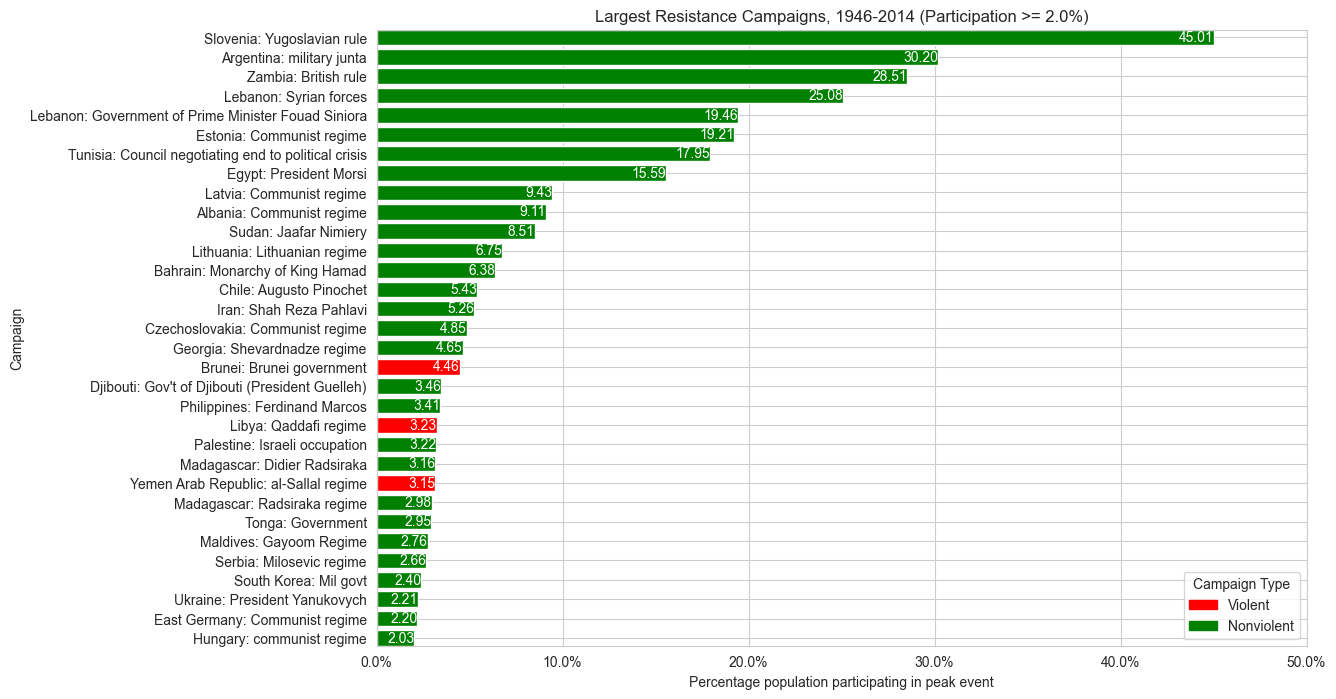

In [15]:
# Create the same plot as above, but with the campaign type (violent or nonviolent) as the color
# Green for nonviolent and red for violent
plt.figure(figsize=(12, 8))
bars = plt.barh(large_campaigns_sorted_desc['Label'], large_campaigns_sorted_desc['PERCENTAGEPOPULARPARTICIPATION'],
                color=large_campaigns_sorted_desc['VIOL'].apply(lambda x: 'red' if x == 1 else 'green'))

# Add the percentages at the end of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='right', color='white')

# Adding a legend for color meanings
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in ['red', 'green']],
           labels=['Violent', 'Nonviolent'],
           title="Campaign Type")
# Setting the margins to 0 to remove the extra space
plt.margins(0, 0)
# Setting the remaining plot elements
plt.xlabel('Percentage population participating in peak event')
plt.xlim(0, 50)
# Setting the x-ticks to show percentages
plt.xticks([0, 10, 20, 30, 40, 50], ['0.0%', '10.0%', '20.0%', '30.0%', '40.0%', '50.0%'])
plt.ylabel('Campaign')
plt.title('Largest Resistance Campaigns, 1946-2014 (Participation >= 2.0%)')
# Set the grid behind the bars
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

In [16]:
large_campaigns_sorted_desc['NONVIOL'].value_counts()

NONVIOL
1.0    29
0.0     3
Name: count, dtype: int64

We can clearly see that the top campaigns have been nonviolent, except for 3 campaigns and only one of them was successful. This is a very interesting observation, as it shows that nonviolent campaigns have a higher success rate than violent campaigns and that nonviolent campaigns are more likely to be larger than violent campaigns. Most of the top campaigns had been nonviolent and successful or partially successful, which is a good sign for the effectiveness of nonviolent campaigns, especially when they have a high participation percentage.

Now let's proceed, outside the largest resistance campaigns, if we can find anything about **Greece**.

We will now use the full navco dataset to find out more about the campaigns in Greece.

In [17]:
greece_campaigns = navco_full[navco_full['LOCATION'] == 'Greece']
greece_campaigns

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,...,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
119,401.0,Greek Civil War,Greece,1946.0,1949.0,British and US occupation,0.0,0.0,1.0,0.0,...,0.0,1778.0,40000.0,0.005092,1.0,0.0,NaN,0.0,1.0,1.0
120,89.0,Greek anti-military,Greece,1973.0,1974.0,Military rule,1.0,0.0,0.0,0.0,...,0.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


### We can see that in Greece there were two campaigns, one in 1949 and one in 1974
Lets see what happened in 1949 and analyze the data for that span of time

### Greek Civil War (1946-1949):

* **Duration**: This campaign occurred from 1946 to 1949, lasting approximately 1778 days.

* **Target**: It was directed against the British and US occupation forces in Greece.

* **Nature of the Campaign**: The campaign was violent in nature (`VIOL: 1.0`) and involved a struggle for self-determination (`FSELFDET: 1.0`). It was not a secessionist movement (`SECESSION: 0.0`) nor did it lead to a regime change (`REGCHANGE: 0.0`).
  
* **Outcome**: The campaign was not successful (`SUCCESS: 0.0`), indicating a failure to achieve its primary objectives. This is further emphasized by the `FAILURE` column being marked as 1.0.
  
* **Participation and Support**: Approximately 40,000 individuals participated in the campaign, constituting about 0.509% of the population. The campaign received violence from the regime (`REGVIOL: 1.0`) and state support (from Russia) (`STATESUP: 1.0`), as well as regular aid (`REGAID: 1.0`).
  
* **Violent Characteristics**: The dataset does not provide specific details about a violent flank within the campaign. There was no significant similarity in violence with other campaigns (`VIOLSIM: 0.0`), and no significant defections were reported (`DEFECT: 0.0`).

**Conclusion**:
The Greek Civil War represents a significant period in Greek history, characterized by its violent nature and the involvement of foreign forces. Despite substantial participation and external support, the campaign ultimately failed to achieve its goals. The struggle for self-determination and the lack of a regime change highlight the complex political and social dynamics of the period.



We can also get some more information about the Greek Civil War from the polity dataset.

In [18]:
# Get the polity data for Greece where the year is between 1946 and 1949
polity_greece = polity[(polity['country'] == 'Greece') & (polity['year'] >= 1946) & (polity['year'] <= 1949)]
polity_greece

,p5,cyear,ccode,scode,country,year,flag,fragment,democ,autoc,...,interim,bmonth,bday,byear,bprec,post,change,d5,sf,regtrans
6016,0,3501946,350,GRC,Greece,1946,0,NaN,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6017,0,3501947,350,GRC,Greece,1947,0,NaN,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6018,0,3501948,350,GRC,Greece,1948,0,NaN,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6019,0,3501949,350,GRC,Greece,1949,0,NaN,7,3,...,NaN,10.0,17.0,1949.0,1.0,4.0,-4.0,1.0,NaN,-1.0


As we can see from the Polity dataset reveals several interesting insights about the political regime and its changes during the period 1946-1949:

* **Stable Institutionalized Democracy Until 1949**: For the years 1946 to 1948, Greece is consistently coded with a high democracy score (`DEMOC`) of 8 and a low autocracy score (`AUTOC`) of 0. This suggests that, despite the ongoing civil conflict, Greece maintained a relatively high level of institutionalized democracy.

* **Polity Score and Changes in 1949**: The `POLITY` and `POLITY2` scores, which are derived by subtracting the `AUTOC` score from the `DEMOC` score, are both at 8 for 1946-1948, indicating a stable democratic regime. However, in 1949, these scores drop to 4, a significant decrease, reflecting a major shift in the political regime.

* **Executive Recruitment and Constraints**: The variables `XRREG`, `XRCOMP`, `XROPEN` (all concerning the process of executive power transitions), and `XCONST` (measuring constraints on executive decisions) remain consistent from 1946 to 1949, indicating stable patterns in executive recruitment and constraints despite the war.

* **Regulation and Competitiveness of Political Participation**: The `PARREG` and `PARCOMP` scores indicate some change in the nature of political participation. Initially, the `PARREG` score is 2 (Multiple Identity), but in 1949, it changes to 4 (Restricted), suggesting increasing restrictions on political participation. Similarly, the `PARCOMP` score changes from 3 (Factional) in 1946-1948 to 2 (Suppressed) in 1949, indicating a reduction in political competition.

* **Regime Change in 1949**: The `CHANGE` score in 1949 is -4, signifying a negative shift in the regime type. The `REGTRANS` score of -1 in 1949 further confirms a negative regime change, indicating a decline in democratic qualities.

* **End of Transition and New Beginning**: The `EPREC`, `INTERIM`, `BPREC` variables, along with specific day and month codes (`EMONTH`, `EDAY`, `EYEAR`, `BMONTH`, `BDAY`, `BYEAR`), indicate a regime transition occurring in 1949. The exact date is marked with precision (`EPREC` and `BPREC` both at 1), suggesting a clear and well-documented transition point.

* **State Failure Indicator**: The `SF` column is blank, indicating there was no complete collapse of central authority or state failure during this period.

* **Regime Transition Category**: The `REGTRANS` value of -1 in 1949 signifies a negative regime change, but not a major adverse transition or state failure.

Overall, these data points paint a picture of Greece maintaining a fairly stable democratic regime during the initial years of the civil war but experiencing a significant shift in its political structure by the end of the conflict in 1949. This shift involved reduced democracy, increased autocracy, and more restricted and suppressed political participation.


Now lets see what happened in 1974 and analyze the data for that span of time

### Greek anti-military campaign (1973-1974):

Based on the data from the NAVCO dataset for the Greek anti-military campaign (1973-1974), here are some key insights:

1. **Campaign Against Military Rule**: The campaign targeted the military rule in Greece, indicating a political movement focused on changing the existing regime.

2. **Success of the Campaign**: The campaign is marked as successful (`SUCCESS = 1.0`), meaning it achieved its primary objectives. This success could entail significant political changes, possibly contributing to the end of the military regime.

3. **Nonviolent Nature**: The campaign was nonviolent (`NONVIOL = 1.0`), indicating that it did not resort to armed struggle or violent tactics. This aligns with historical accounts of the period, which saw significant civil resistance against the military junta.

4. **Regime Change**: The campaign contributed to a regime change (`REGCHANGE = 1.0`), a significant outcome, especially considering the context of military dictatorship.

5. **Duration and Participation**: The campaign lasted for 654 days, involving approximately 2500 participants. The `PERCENTAGEPOPULARPARTICIPATION` is quite low (around 0.000279), suggesting that while the campaign was significant in its impact, it involved a relatively small proportion of the population directly.

6. **Defection and Violent Flank**: There were instances of defection (`DEFECT = 1.0`) within or from the regime, and the presence of a violent flank (`VIOLENTFLANK = 1.0`) is noted, which could indicate that while the main campaign was nonviolent, there were elements or parallel movements that employed violence.

7. **No External Support**: The campaign did not receive regular external support (`REGAID = 0.0`) or support from state actors (`STATESUP = 0.0`), suggesting it was primarily a domestic movement without significant foreign intervention.

8. **Violation of Rights and Similar Movements**: The campaign occurred in a context where violations of rights were evident (`REGVIOL = 1.0`), and there were similar movements or campaigns (`VIOLSIM = 1.0`), possibly indicating a broader context of civil resistance against the military regime in Greece during this period.

This data reflects a significant period in modern Greek history, where nonviolent civil resistance played a crucial role in bringing about political change and the eventual restoration of democracy.


Now let's get some more information about the Greek anti-military campaign from the polity dataset.

In [19]:
# Get the polity data for Greece where the year is between 1973 and 1974
polity_greece = polity[(polity['country'] == 'Greece') & (polity['year'] >= 1973) & (polity['year'] <= 1974)]
polity_greece

,p5,cyear,ccode,scode,country,year,flag,fragment,democ,autoc,...,interim,bmonth,bday,byear,bprec,post,change,d5,sf,regtrans
6043,0,3501973,350,GRC,Greece,1973,0,NaN,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6044,0,3501974,350,GRC,Greece,1974,0,NaN,-88,-88,...,-88.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3.0


### Insights from the Polity Dataset for Greece (1973-1974):

* **Political Regime Change in 1973-1974**:
  * **1973**:
    * **DEMOC and AUTOC Scores**: In 1973, Greece had a `DEMOC` (Institutionalized Democracy) score of `0` and an `AUTOC` (Institutionalized Autocracy) score of `7`, resulting in a `POLITY` and `POLITY2` score of `-7`, indicating a highly autocratic regime.
    * **Executive Recruitment and Constraints**: The `XRREG` (Regulation of Chief Executive Recruitment), `XRCOMP` (Competitiveness of Executive Recruitment), `XROPEN` (Openness of Executive Recruitment), and `XCONST` (Executive Constraints) scores were all low (`1` and `0`), reflecting a non-competitive, closed, and autocratically managed executive branch.
    * **Political Participation**: `PARREG` (Regulation of Participation) and `PARCOMP` (Competitiveness of Participation) scores were both `1`, signifying repressed political participation and highly restricted political competition.
    * **Regime Durability**: The `DURABLE` score of `6.0` suggests that the autocratic regime had been stable for some years before 1973.
  
  * **1974**:
    * **Transition Period**: The year 1974 is marked by a transition period, as indicated by the `-88` codes across multiple variables, including `DEMOC`, `AUTOC`, `POLITY`, `XRREG`, `XRCOMP`, `XROPEN`, `XCONST`, `PARREG`, and `PARCOMP`. This signifies an interruption or transition in the standard functioning of the political system.
    * **Regime Change Details**: The transition details are marked with specific dates (`EMONTH`: `7`, `EDAY`: `23`, `EYEAR`: `1974`) or `23/7/1974`, and the precision of this transition is high (`EPREC`: `1`), indicating a well-documented and significant change in the political regime.
    * **Post-Transition Regime**: After the transition, the `POST` regime score becomes `0`, reflecting a neutral or undefined political regime immediately following the transition.
    * **Regime Transition Score**: The `REGTRANS` score of `3` in 1974 indicates a major democratic transition, signifying a substantial shift towards a more democratic regime.

**Overall Conclusion**:
The period 1973-1974 in Greece was marked by significant political upheaval, transitioning from a highly autocratic regime in 1973 to a major democratic transition in 1974. This period was characterized by a transition to more open and competitive political structures, reflecting a pivotal moment in Greece's political history.


> An interesting observation it that the Greek Civil War was a violent campaign and the Greek anti-military campaign was a nonviolent campaign. Also, the Greek Civil War was not successful while the Greek anti-military campaign was successful. The Greek Civil War had a bigger duration than the Greek anti-military campaign. It is also interesting that the Greek Civil War had more participants than the Greek anti-military campaign. 

Although there are a lot of complex factors that contributed to the outcomes of these campaigns, it is interesting to see that the Greek anti-military campaign was successful, despite being nonviolent and having fewer participants than the Greek Civil War. This could be attributed to the fact that the Greek anti-military campaign was more focused on a specific goal (ending the military regime) and had a more cohesive and organized structure, and is also very important to keep in mind the Cyprus Invasion of 1974 at the time of the Greek anti-military campaign, which had a significant impact on the outcome of the campaign. On the other hand, the Greek Civil War was a more complex conflict with multiple actors and objectives.

## 3. The Effect of Participation on the Probability of Campaign Success

We will examine the effect of participation on the probability of campaign success. We will run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends.

First, we will drop the rows with null values for participation.

In [20]:
navco_logit = navco[navco['PARTICIPATION'].notna()].copy()

Now, we will calculate the population column where it is defined as the number of participants divided by the percentage of popular participation.

Then, we will calculate the logarithm of the population and the logarithm of the participation.

In [21]:
navco_logit['POPULATION'] = navco_logit['PARTICIPATION'] / navco_logit['PERCENTAGEPOPULARPARTICIPATION']
# Convert POPULATION to integer
navco_logit['POPULATION'] = navco_logit['POPULATION'].astype(int)
# Calculate the logarithm of the population and the participation
navco_logit['LOG_POPULATION'] = navco_logit['POPULATION'].apply(lambda x: np.log(x))
navco_logit['LOG_PARTICIPATION'] = navco_logit['PARTICIPATION'].apply(lambda x: np.log(x))

Now, we will calculate the membership per capita column where it is defined as the logarithm of the participation divided by the logarithm of the population..

The membership per capita is a measure of the number of participants per capita and is defined as such in the [1.1 version of the NAVCO dataset.](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YLLHEE)

`MEMPC Author’s calculation; Penn
World Tables 6.2
Membership per capita
(lmembers/lnpop)`

To better visualize the membership per capita equation, we will use the following formula:

$$Membership per capita = \frac{ln(participation)}{ln(population)}$$


In [22]:
navco_logit['MEMBERSHIPPERCAPITA'] = navco_logit['LOG_PARTICIPATION'] / navco_logit['LOG_POPULATION']
navco_logit

,LOCATION,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,NONVIOL,VIOL,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,POPULATION,LOG_POPULATION,LOG_PARTICIPATION,MEMBERSHIPPERCAPITA
0,Afghanistan,1979.0,Afghan government,1.0,0.0,0.0,0.0,1.0,10000.0,0.000641,15600000,16.562781,9.210340,0.556087
1,Afghanistan,1989.0,Soviet occupation,1.0,0.0,0.0,0.0,1.0,10000.0,0.000685,14600000,16.496532,9.210340,0.558320
2,Afghanistan,1996.0,Afghan regime,1.0,0.0,0.0,0.0,1.0,20000.0,0.000893,22400000,16.924572,9.903488,0.585154
3,Afghanistan,2014.0,Afghan government,0.0,0.0,1.0,0.0,1.0,60000.0,0.001625,36921089,17.424293,11.002100,0.631423
4,Albania,1991.0,Communist regime,1.0,0.0,0.0,1.0,0.0,300000.0,0.091068,3294227,15.007682,12.611538,0.840339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,Zambia,1963.0,British rule,1.0,0.0,0.0,1.0,0.0,1000000.0,0.285063,3508000,15.070557,13.815511,0.916722
385,Zambia,1991.0,One-party rule,1.0,0.0,0.0,1.0,0.0,23000.0,0.002791,8239732,15.924478,10.043249,0.630680
386,Zambia,2001.0,Chiluba regime,1.0,0.0,0.0,1.0,0.0,3000.0,0.000277,10824125,16.197288,8.006368,0.494303
387,Zimbabwe,1979.0,Smith/Muzorena regime,0.0,1.0,0.0,0.0,1.0,1000.0,0.000145,6887132,15.745165,6.907755,0.438722


Now that we have created the membership per capita column, we can start with the creation of the logistic regression model.

In [23]:
# Prepare the logistic regression model
X = navco_logit[['MEMBERSHIPPERCAPITA', 'POPULATION']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = navco_logit['SUCCESS']
#Fit the model
model = logit("SUCCESS ~ MEMBERSHIPPERCAPITA + np.log(POPULATION) ", navco_logit).fit()
#Print the summary of the regression
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6
                          Results: Logit
Model:               Logit            Method:           MLE       
Dependent Variable:  SUCCESS          Pseudo R-squared: 0.130     
Date:                2023-12-04 01:59 AIC:              447.3747  
No. Observations:    380              BIC:              459.1952  
Df Model:            2                Log-Likelihood:   -220.69   
Df Residuals:        377              LL-Null:          -253.58   
Converged:           1.0000           LLR p-value:      5.1893e-15
No. Iterations:      6.0000           Scale:            1.0000    
------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------
Intercept           -2.8142   1.4961 -1.8811 0.0600 -5.7465 0.1180
MEMBERSHIPPERCAPITA  7.6475   1.1664  6.5563 0.0000  

Our logistic regression can be depicted by the following equation:

$$log(\frac{p}{1-p}) = -2.8142 + 7.6475 * MEMBERSHIPPERCAPITA - 0.1388 * np.log(POPULATION)$$

where $p$ is the probability of campaign success.


### Model Overview:
- The model has a `Pseudo R-squared` value of `0.130`, which indicates a low to moderate explanatory power. While this measure is not directly comparable to R-squared in linear regression, it suggests the model explains a reasonable proportion of the variance in campaign success.

### Coefficients and Significance:
- The `Intercept` coefficient is `-2.8142`, but its `p-value` is `0.0600`, suggesting it is not statistically significant at the conventional 0.05 level. This means that, when all other variables are at zero, the log odds of campaign success is -2.8142.
- The coefficient for `MEMBERSHIPPERCAPITA` is 7.6475 with a `p-value` of `0.0000`, indicating a very strong and statistically significant positive effect on campaign success. This suggests that higher membership per capita substantially increases the odds of a campaign's success.
- The coefficient for `np.log(POPULATION)` is -0.1388. Its `p-value` is `0.0591`, which is slightly above the conventional threshold for significance. This suggests a potential negative effect of population size on campaign success, but this effect is not as statistically robust as the effect of membership per capita.

### Model Fit and Statistical Testing:
- The model's `Log-Likelihood Ratio (LLR)` p-value is extremely low `(5.1893e-15)`, indicating that the model is a significant improvement over the null model (which includes only the intercept).

### Implications:
- This model suggests that the per capita membership in a campaign is a crucial factor in predicting its success, while the overall population size has a smaller and less certain impact.
- Given the high coefficient for `MEMBERSHIPPERCAPITA`, campaigns with higher participation relative to the total population are significantly more likely to succeed.

Having prepared the logistic regression model, we can now proceed to check the multicollinearity of the independent variables.
We will use the Variance Inflation Factor (**VIF**) to check for multicollinearity.

In [24]:
# Instantiate the VIF dataframe
vif = pd.DataFrame()
# Get the VIF values for each variable
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(2)

,VIF Factor,features
0,31.40,const
1,1.08,MEMBERSHIPPERCAPITA
2,1.08,POPULATION


We can see that all predictor variables have VIF values well below the commonly used threshold of 5, indicating that multicollinearity is not a concern in this model. Each predictor appears to contribute independently to the model, allowing for a more reliable interpretation of their individual effects on the dependent variable.

The high VIF for the constant is not unusual and typically does not indicate a problem. The VIF for the intercept term in a regression model can often be very high without indicating any issues with multicollinearity among the predictor variables.

**Conclusion**:
The low VIF values for `MEMBERSHIPPERCAPITA` and `POPULATION` suggest that these variables can be safely used in the regression model without worrying about multicollinearity affecting the accuracy of the estimates.

Let's also perform a (forward) stepwise regression to see which variables are the most important for the success rate.
For this action we will use the `sklearn` for the logistic regression and the `mlxtend` for the stepwise regression.
We will use the `forward` method for the stepwise regression and the scoring method will be the `r2` (`R squared`).

In [25]:
# Prepare the data in the same format used to fit the model
X = navco_logit[['MEMBERSHIPPERCAPITA', 'POPULATION']]
y = navco_logit['SUCCESS']

# Prepare the logistic regression model
clf = linear_model.LogisticRegression(n_jobs=-1, random_state=0)  # We parallelize the process using all available cores

# Build step forward feature selection with the use of mxlend
sfs1 = sfs(clf, forward=True, floating=False, scoring='r2', cv=5, n_jobs=-1,
           k_features='best')  # We parallelize the process using all available cores, and perform 5-fold cross-validation

# Perform SFFS
selected_features = sfs1.fit(X, y)
# See the selected features
selected_features.k_feature_names_

('MEMBERSHIPPERCAPITA',)

As we can see from the results, the stepwise regression selected only the `MEMBERSHIPPERCAPITA` variable as the most important variable for the success rate and the `POPULATION` variable was not selected. Accounting for the fact that the `POPULATION` variable was not statistically significant in the logistic regression model, we can conclude that the `MEMBERSHIPPERCAPITA` variable is the most important variable for the success rate.

---

Now that we have prepared our model, we can use it to predict the success rate for different values of the membership per capita and the population.

With that information, we can create a scatter plot of the membership per capita vs. the probability of success.

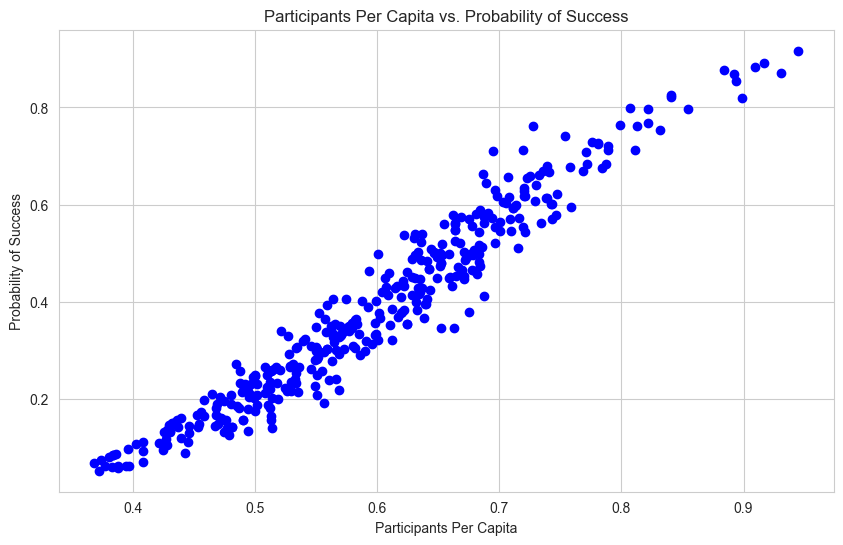

In [26]:
# Predict the probability of success
navco_logit['PredictedProbability'] = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter((navco_logit['MEMBERSHIPPERCAPITA']), navco_logit['PredictedProbability'], color='blue')
plt.xlabel('Participants Per Capita')
plt.ylabel('Probability of Success')
plt.title('Participants Per Capita vs. Probability of Success')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

As we can see from the results, the probability of success increases as the participants per capita increases. We can see that the scatterplot is sparse but linear, which is explained by the unpredictable nature of the population variable that has a negative effect on the probability of success. Probably, the plot is more sparse due to the population variable that is influencing the results in its own dimension that we cannot see in this plot clearly.

Now, we will do the same but with only the membership per capital as dependent variable.

In [27]:
# Prepare the logistic regression model
X = navco_logit[['MEMBERSHIPPERCAPITA']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = navco_logit['SUCCESS']
#Fit the model
model = logit("SUCCESS ~ MEMBERSHIPPERCAPITA", navco_logit).fit()
#Print the summary of the regression
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6
                          Results: Logit
Model:                Logit            Method:           MLE       
Dependent Variable:   SUCCESS          Pseudo R-squared: 0.123     
Date:                 2023-12-04 01:59 AIC:              449.0222  
No. Observations:     380              BIC:              456.9026  
Df Model:             1                Log-Likelihood:   -222.51   
Df Residuals:         378              LL-Null:          -253.58   
Converged:            1.0000           LLR p-value:      3.2041e-15
No. Iterations:       6.0000           Scale:            1.0000    
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -5.3469   0.7095 -7.5362 0.0000 -6.7375 -3.9563
MEMBERSHIPPERCAPITA  8.0495   1.1414  7.0

Our logistic regression can be depicted by the following equation:

$$log(\frac{p}{1-p}) = -5.3469 + 8.0495 * MEMBERSHIPPERCAPITA$$

where $p$ is the probability of campaign success.



### Model Overview:

- **Pseudo R-squared**: At `0.123`, it suggests a low to moderate level of explanatory power. This metric helps understand how well the model explains the variability in the outcome. We can see that the Pseudo R-squared value is lower than the previous model, which included the population variable.

### Model Fit and Statistical Significance:

- **LLR p-value**: Extremely low at `3.2041e-15`, implying the model is significantly better than a null model (which includes only the intercept).

### Coefficients:

- **Intercept**: The coefficient of -5.3469 (highly significant with `p < 0.0001`) indicates the log odds of success when `MEMBERSHIPPERCAPITA` is zero.
- **MEMBERSHIPPERCAPITA**: This variable has a coefficient of 8.0495, significantly affecting campaign success `(p < 0.0001)`. This suggests a strong positive relationship between membership per capita and the likelihood of campaign success.

### Interpretation:

- The high coefficient for `MEMBERSHIPPERCAPITA` indicates that as the membership per capita increases, the probability of campaign success increases significantly.
- Given the model's significance and the coefficient of `MEMBERSHIPPERCAPITA`, campaigns with higher levels of participation relative to the population size have substantially higher chances of success.
- The model, while simplified (only one predictor), demonstrates the importance of widespread participation in the effectiveness of campaigns.

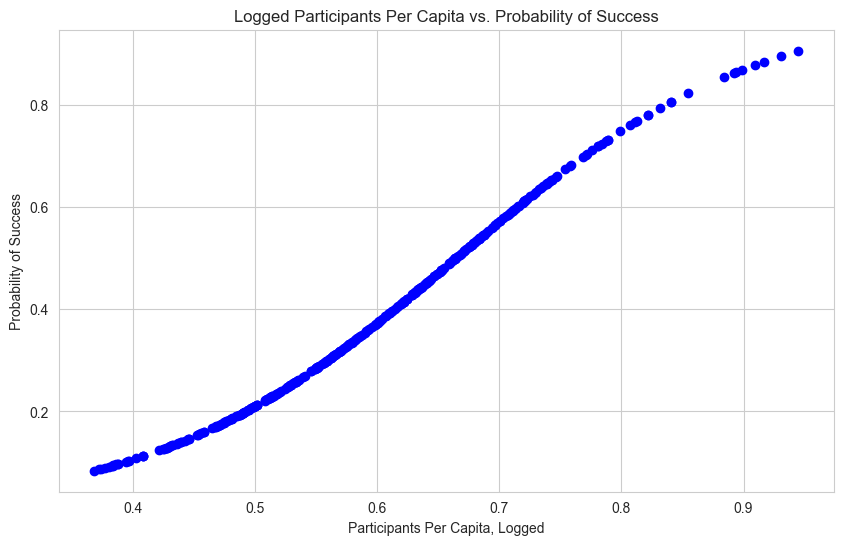

In [28]:
# Prepare the features for prediction
X = sm.add_constant(navco_logit[['MEMBERSHIPPERCAPITA']])  # Assuming 'LogPopulation' is another feature in your model
# Predict the probability of success
navco_logit['PredictedProbability'] = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter((navco_logit['MEMBERSHIPPERCAPITA']), navco_logit['PredictedProbability'], color='blue')
# Show the population on a logarithmic scale
plt.xlabel('Participants Per Capita, Logged')
plt.ylabel('Probability of Success')
plt.title('Logged Participants Per Capita vs. Probability of Success')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

As we can see from the results, the probability of success increases as the participants per capita increase. The scatterplot is in the form of an S-curve (sigmoid function). The plot is not sparse at all, and it is more "sigmoid" looking than the previous one. This is due to the fact that we have only one variable in this model and the population variable is not influencing the results, so we are depicting the results in a 2D space more accurately and clearly.

**Conclusion**:
The addition of the population variable in the first model changes the dynamics of the prediction. 
The scatterplot for this model doesn't just reflect changes in `MEMBERSHIPPERCAPITA`, but also how these changes interact with the population size to influence the likelihood of success. 
The second model's scatterplot is more straightforward, showing a direct relationship between `MEMBERSHIPPERCAPITA` and campaign success without the additional influence of population size.

## 4. The Level of Participation Tipping Point

As we mentioned above, a famous output of the research is the 3.5% rule regarding the population participation in a campaign and the probability of success.

Based on our data, we will create a table like the one below and explain how Chenoweth came up with the rule.

But before we start, we need to clean our data by throwing out the rows where participation is `Nan`.

In [29]:
# Drop rows with null values for participation
navco = navco[navco['PARTICIPATION'].notna()].copy()

In [30]:
# Calculate the percentage of popular participation
navco['PercentageParticipation'] = navco['PERCENTAGEPOPULARPARTICIPATION'] * 100

# Define bins and labels
bins = [0, 0.0035, 0.015, 0.06, 0.25, 1, 3.5, np.inf]
labels = ['less than 0.0035%', '0.0035% - 0.015%', '0.015% - 0.06%',
          '0.06% - 0.25%', '0.25% - 1.0%', '1.0% - 3.5%',
          'greater than 3.5%']

# Categorize the campaigns
navco['Peak Popular Participation (%)'] = pd.cut(navco['PercentageParticipation'], bins=bins, labels=labels,
                                                 right=False)

# Calculate observations and success rates
success_rate_by_category = navco.groupby('Peak Popular Participation (%)', observed=True)['SUCCESS'].agg(
    ['count', 'mean'])
# Rename the columns for clarity
success_rate_by_category.rename(columns={'count': 'Observations', 'mean': 'Success Rate'}, inplace=True)
# Convert the success rate to percentage
success_rate_by_category['Success Rate'] = success_rate_by_category['Success Rate'] * 100

# Sort the dataframe by the Peak Popular Participation (%)
success_rate_by_category = success_rate_by_category.sort_values(by='Peak Popular Participation (%)',
                                                                ascending=False).round(2)
success_rate_by_category['Success Rate'] = success_rate_by_category['Success Rate'].astype(str) + '%'
success_rate_by_category.reset_index()

,Peak Popular Participation (%),Observations,Success Rate
0,greater than 3.5%,18,88.89%
1,1.0% - 3.5%,41,60.98%
2,0.25% - 1.0%,92,45.65%
3,0.06% - 0.25%,95,45.26%
4,0.015% - 0.06%,66,24.24%
5,0.0035% - 0.015%,44,9.09%
6,less than 0.0035%,24,4.17%


Let's try to make the table more presentable by using the `prettytable` library.

In [31]:
# Converting it to a list of lists for easier processing with PrettyTable
data = success_rate_by_category.reset_index().values.tolist()
# Create a PrettyTable object
table = PrettyTable()
# Define the column names
table.field_names = ['Peak Popular Participation (%)', 'Observations', 'Success Rate']
# Add rows to the table
for row in data:
    table.add_row(row)
# Present the table
print(table)

+--------------------------------+--------------+--------------+
| Peak Popular Participation (%) | Observations | Success Rate |
+--------------------------------+--------------+--------------+
|       greater than 3.5%        |      18      |    88.89%    |
|          1.0% - 3.5%           |      41      |    60.98%    |
|          0.25% - 1.0%          |      92      |    45.65%    |
|         0.06% - 0.25%          |      95      |    45.26%    |
|         0.015% - 0.06%         |      66      |    24.24%    |
|        0.0035% - 0.015%        |      44      |    9.09%     |
|       less than 0.0035%        |      24      |    4.17%     |
+--------------------------------+--------------+--------------+


Having our table ready, we can start with the explanation of the 3.5% rule.

The 3.5% rule, formulated by political scientist Erica Chenoweth, emerged from her extensive research on civil resistance movements. 
This rule is an empirical finding derived from the analysis of historical data on various campaigns, both violent and nonviolent.

A crucial aspect of their analysis was the level of active participation in these campaigns, measured as a percentage of the total population. This allowed for comparison across different countries and contexts.

 Chenoweth found that no campaign that had mobilized approximately 3.5% of the population had failed to achieve its goals. This was a consistent pattern observed across various movements, irrespective of their geographical location or political context.

Based on this empirical observation, Chenoweth proposed the 3.5% rule. It posits that once a movement mobilizes about 3.5% of the population in sustained resistance, it almost always reaches a tipping point leading to success. This rule suggests a critical mass needed for a high likelihood of achieving political or social change.

It's important to understand that the 3.5% rule is not a strict formula guaranteeing success. Instead, it reflects a pattern observed in historical data. The success of a movement depends on various factors, including the nature of the regime, the type of resistance, and other contextual elements.

---

### Now, to find the percentage of the population that is the tipping point for success in a campaign with 99% probability.

 For that we will use the last logistic regression model that we created, where we used the participation per capita logged as the independent variable and the success rate as the dependent variable.

We will get the parameters of the model, and we will use them to calculate the success rate for different values of the participation per capita logged.

For our model we have the formula:

$$
\log \left(\frac{p}{1-p}\right)= intercept + coeficient x_{1}
$$

where $x_{1}$ is the participation per capita logged.

To find the tipping point for the participation per capita logged, we need to find the value of $x_{1}$ where the success rate is 99%:

$$
x_{1}=\frac{\log \left(\frac{p}{1-p}\right)-intercept}{coeficient}
$$

where $p$ is the success rate.

In [32]:
# Parameters of the model
coef = model.params['MEMBERSHIPPERCAPITA']
intercept = model.params['Intercept']

# Define the success probability threshold
success_probability_threshold = 0.99

# Calculate the log odds for 99% probability
log_odds = np.log(success_probability_threshold / (1 - success_probability_threshold))

# Calculate the tipping point for participation per capita logged
tipping_point = (log_odds - intercept) / coef

However, we need to convert the tipping point for the participation per capita logged to the tipping point for the participation per capita.
So, to do that we will exponentiate the tipping point for the participation per capita logged.

In [33]:
# Raise the tipping point to the power of e to get the real tipping point for the population
tipping_point = np.exp(tipping_point)
print(f'The tipping point for the participation per capita is {tipping_point:.2f}%')

The tipping point for the participation per capita is 3.44%


We can observe that the tipping point that we got here is lower than the 3.5% (**3.44%**) rule that Chenoweth proposed. This may stem from the fact that the model that we are using has a low explanatory power (`pseudo R-squared` of `0.123`), and we are using only one variable to predict the success rate, which is not enough to get a more accurate result for the tipping point.



### However

It is crucial to mention that our regression model doesn't reach the tipping point for the participation per capita logged at 99% probability. It must be mentioned that our model is simply an approximation of the real world and it is not perfect.

Diving deep into the equation of the membership per capita,

$$membership per capita = \frac{ln(participation)}{ln(population)}$$

we can get the result:

$$ \frac{participation}{population} = population^{0.2351102366773823}$$

Meaning that the tipping point for the percentage of popular participation is influenced by the population size of each campaign. The bigger the population size, the bigger the tipping point for the percentage of popular participation.

Let's now dive deep into the percentage of popular participation and check again the scatter plot of the percentage of membership per capita vs. the predicted probability of success, but this time we will also plot the confidence interval for 90% confidence, so we can get a better understanding of the tipping point for the percentage of popular participation.

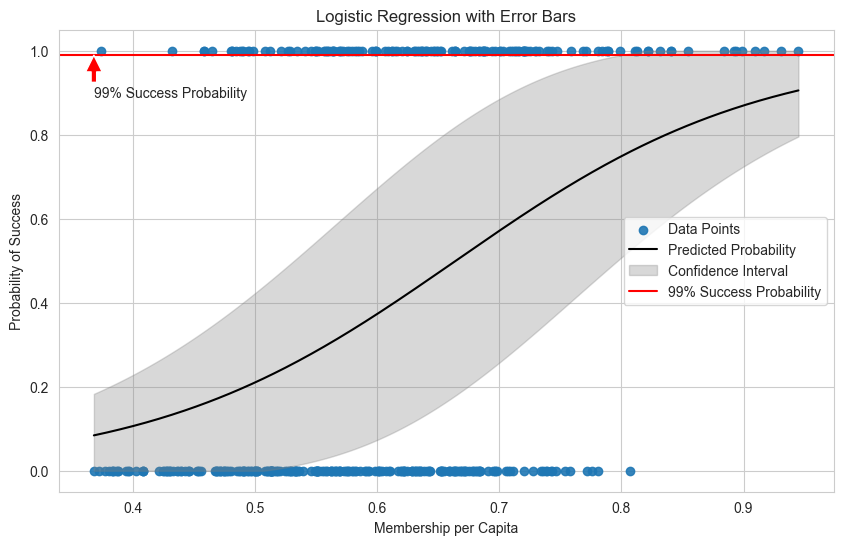

In [34]:
from scipy.stats import norm

# Calculate predicted probabilities
x = np.linspace(navco_logit['MEMBERSHIPPERCAPITA'].min(), navco_logit['MEMBERSHIPPERCAPITA'].max(), 380)
x_with_const = sm.add_constant(pd.DataFrame({'MEMBERSHIPPERCAPITA': x}))
predicted_probs = model.predict(x_with_const)

# Calculate standard errors for the predictions
pred_std_err = model.predict(x_with_const, transform=False) * (1 - model.predict(x_with_const))
# Approximate 90% confidence interval
ci = norm.ppf(0.90) * pred_std_err
# Calculate upper and lower bounds for confidence intervals
lower_bounds = predicted_probs - ci
upper_bounds = predicted_probs + ci

# Clip the bounds to be within [0, 1]
lower_bounds = np.clip(lower_bounds, 0, 1)
upper_bounds = np.clip(upper_bounds, 0, 1)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(navco_logit['MEMBERSHIPPERCAPITA'], navco_logit['SUCCESS'], alpha=0.9, label='Data Points')
plt.plot(x, predicted_probs, color='black', label='Predicted Probability')
plt.fill_between(x, lower_bounds, upper_bounds, color='grey', alpha=0.3, label='Confidence Interval')
plt.xlabel('Membership per Capita')
plt.ylabel('Probability of Success')
plt.title('Logistic Regression with Error Bars')
# Plot y=0.99 for the tipping point of 99% success probability
success_line = 0.99
plt.axhline(y=success_line, color='red', label='99% Success Probability')
plt.annotate('99% Success Probability', xy=(x.min(), success_line), xytext=(x.min()*1, success_line-0.1),
             arrowprops=dict(facecolor='red', shrink=0.01), ha='left')
plt.legend()
plt.ylim(-0.05, 1.05)  # Ensure the probability is between 0 and 1
plt.grid(True)
plt.show()

We can observe that in the confidence interval, for membership per capita values close to 0.8, the confidence interval touches for the first time the tipping point of 99% success probability. This means that the tipping point for the participation per capita logged could be around 0.8.

If we observe our data closely, we can see that for membership per capita values close to 0.8 we have the percentage of popular participation values from 3.41% and above, where there is only one failure (reported 88.89% as the tipping point from our table in the fourth section of this notebook). However, this difference may stem from the fact that our model is not perfect, and it is simply an approximation of the real world, which is important to keep in mind.

We also know for a fact that the membership per capita and percentage of popular participation are monotonically increasing, which means that the higher the percentage of popular participation, for example, the higher the probability of success.

We can see that the success rate is 100% for the percentage of popular participation values close to 6.39% and above, so it would be maybe safer to assume that the tipping point for the percentage of popular participation is around 6.39%. We cannot make definite conclusions, for the reasons mentioned above, but we can assume that the tipping point for the percentage of popular participation is somewhere around 6.39%.

In [35]:
# Get rows where the membership per capita is greater than 0.8
navco_logit[(navco_logit['MEMBERSHIPPERCAPITA'] >= 0.8)][['MEMBERSHIPPERCAPITA', 'PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']].sort_values(by='PERCENTAGEPOPULARPARTICIPATION', ascending=True)

,MEMBERSHIPPERCAPITA,PERCENTAGEPOPULARPARTICIPATION,SUCCESS
266,0.811163,0.034130,1.0
80,0.812648,0.048544,1.0
158,0.831294,0.052632,1.0
63,0.822027,0.054264,1.0
19,0.807094,0.063816,0.0
201,0.821769,0.067492,1.0
314,0.854833,0.085106,1.0
4,0.840339,0.091068,1.0
187,0.840363,0.094319,1.0
98,0.898510,0.155889,1.0


In [36]:
# Get the count of successes where the membership per capita is greater than 0.8, and the percentage of popular participation is greater than 6.39%
navco_logit[(navco_logit['MEMBERSHIPPERCAPITA'] >= 0.8) & (navco_logit['PERCENTAGEPOPULARPARTICIPATION'] >= 0.0639)][['MEMBERSHIPPERCAPITA', 'PERCENTAGEPOPULARPARTICIPATION', 'SUCCESS']].sort_values(by='PERCENTAGEPOPULARPARTICIPATION', ascending=True).value_counts('SUCCESS')

SUCCESS
1.0    12
Name: count, dtype: int64

**In conclusion**:
 Based on our data, we can say that the tipping point for the percentage of popular participation is around **6.39%**, if not in the **3.41%** range.

## 5. Nonviolent Resistance and Target Regime Type

We will examine whether nonviolent resistance remains significant even if we control for the regime type. We will run a logistic regression of success on the nonviolence indicator controlling for the Polity V score of campaign target, the log of participation, and the location’s logged population the year the campaign ends.

For our analysis we will use the `polity2` scores as they are the Revised Combined Polity Score, since the range of the polity2 scores is from -10 to 10, where -10 is the lowest value and 10 is the highest value, having been revised and updated from the -66,-77,-88 polity scores.

Let's begin by creating a new dataframe that will contain the columns we need from the navco and polity datasets.

In [37]:
# Read the polity data again, this time only the columns we need
polity = polity[['country', 'year', 'polity2']]

# Merge the polity data with the NAVCO data
navco_data_merged = pd.merge(navco, polity, left_on=['LOCATION', 'EYEAR'], right_on=['country', 'year'], how='left')
navco_data_merged['POPULATION'] = navco_data_merged['PARTICIPATION'] / navco_data_merged[
    'PERCENTAGEPOPULARPARTICIPATION']

# Keep only the necessary columns ['polity2','EYEAR', 'PARTICIPATION', 'POPULATION', 'SUCCESS', 'NONVIOL']
navco_data_merged = navco_data_merged[['polity2', 'year', 'PARTICIPATION', 'POPULATION', 'SUCCESS', 'NONVIOL']]

# Drop nan values (Remember that we have already filtered the data for 
# non-null values in the 'PARTICIPATION' column for the navco dataframe)
navco_data_merged.dropna(inplace=True)

# Show data
navco_data_merged

,polity2,year,PARTICIPATION,POPULATION,SUCCESS,NONVIOL
1,-8.0,1989.0,10000.0,1.460000e+07,1.0,0.0
2,-7.0,1996.0,20000.0,2.240000e+07,1.0,0.0
3,-1.0,2014.0,60000.0,3.692109e+07,0.0,0.0
4,3.0,1991.0,300000.0,3.294227e+06,1.0,1.0
5,-8.0,1962.0,39000.0,1.100000e+07,1.0,0.0
...,...,...,...,...,...,...
370,-6.0,1998.0,10000.0,1.060000e+07,0.0,1.0
371,-5.0,1992.0,12500.0,1.050000e+07,1.0,0.0
376,6.0,1991.0,23000.0,8.239732e+06,1.0,1.0
377,5.0,2001.0,3000.0,1.082412e+07,1.0,1.0


Before we start with the logistic regression model, we will check the skewness of the independent variables.

In [38]:
# Calculate skewness for each feature
skewness_nonviol = skew(navco_data_merged['NONVIOL'])
skewness_polity2 = skew(navco_data_merged['polity2'])

# For log-transformed features, calculate skewness after transformation
skewness_participation_log = skew(np.log(navco_data_merged['PARTICIPATION']))
skewness_population_log = skew(np.log(navco_data_merged['POPULATION']))

print(f"Skewness of NONVIOL: {skewness_nonviol}")
print(f"Skewness of polity2: {skewness_polity2}")
print(f"Skewness of PARTICIPATION (after log): {skewness_participation_log}")
print(f"Skewness of POPULATION (after log): {skewness_population_log}")

Skewness of NONVIOL: 0.196223851807861
Skewness of polity2: -0.07488310488945842
Skewness of PARTICIPATION (after log): 0.5898461067406909
Skewness of POPULATION (after log): 0.4810233171528561


We can see that the skewness of the independent variables is not very high, so we can proceed with the regression model, most of these are in the range of -0.5 to 0.5, which is acceptable. 
Only the `PARTICIPATION` variable is slightly higher than 0.5 but still below 1. 
This indicates a moderate right skew (positive skewness). While the log transformation has likely reduced the skewness, the distribution is still not perfectly symmetrical.

However, a minor skewness is acceptable.

With the new dataframe we will create a new logistic regression model where we will have as independent variables the nonviolence indicator, the polity score of the campaign target, the log of participation and the location's logged population the year the campaign ends and as dependent variable the success rate.

In [39]:
# Prepare the logistic regression model
X = navco_data_merged[['POPULATION', 'polity2', 'NONVIOL', 'PARTICIPATION']]

X = sm.add_constant(X)  # Adds a constant term to the predictor
y = navco_data_merged['SUCCESS']
#Fit the model
model = logit("SUCCESS ~ NONVIOL + polity2 + np.log(PARTICIPATION) + np.log(POPULATION)", navco_data_merged).fit()
#Print the summary of the regression
print(model.summary2())

Optimization terminated successfully.
         Current function value: 0.536938
         Iterations 6
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   SUCCESS           Pseudo R-squared:  0.203     
Date:                 2023-12-04 01:59  AIC:               328.9411  
No. Observations:     297               BIC:               347.4098  
Df Model:             4                 Log-Likelihood:    -159.47   
Df Residuals:         292               LL-Null:           -199.97   
Converged:            1.0000            LLR p-value:       1.0749e-16
No. Iterations:       6.0000            Scale:             1.0000    
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              1.8727   1.4980  1.2501 0.2113 -1.0634  4.8087
NONVIOL         

- **Model Fit and Overall Significance**:
    - The model has a `Pseudo R-squared` of 0.203, indicating a moderate fit to the data. While this is not directly comparable to the R-squared in linear regression, it suggests that the model explains a significant portion of the variance in the success of the campaigns.
    - The `Log-Likelihood Ratio (LLR)` p-value is extremely low `(1.0749e-16)`, indicating that the model as a whole is statistically significant compared to the null model (which includes only the intercept).

- **Intercept**:
    - The intercept has a coefficient of 1.8727, but it is not statistically significant `(p > 0.05)`. This means that when all other variables are at zero, the log odds of a campaign being successful is 1.8727. However, since other variables are rarely zero, the practical significance of the intercept is limited.

- **Nonviolence (`NONVIOL`)**:
    - The coefficient for `NONVIOL` is 0.8662, and it is statistically significant `(p = 0.0033)`. This suggests that nonviolent campaigns have higher log odds of being successful compared to violent campaigns, holding other variables constant.

- **Polity Score (`polity2`)**:
    - The coefficient for `polity2` is 0.0522 and is statistically significant `(p = 0.0397)`. This indicates that higher polity scores (which usually represent more democratic regimes) , although they impact in a subtle manner,are associated with a higher probability of campaign success.

- **Log of Participation (`np.log(PARTICIPATION)`)**:
    - The coefficient is 0.4367 and is highly significant `(p < 0.0001)`. This implies that higher levels of participation increase the log odds of a campaign's success, suggesting that campaigns with more participants are more likely to succeed.

- **Log of Population (`np.log(POPULATION)`)**:
    - The coefficient is -0.4270 and is also highly significant `(p < 0.0001)`. This suggests that larger population sizes are associated with lower odds of campaign success, possibly due to the increased complexity and challenges in mobilizing larger populations.

In summary, the model indicates that nonviolence, a higher level of participation, and targeting more democratic regimes are positively associated with campaign success, while larger population sizes are negatively associated with success. These findings could have implications for the strategic planning and understanding of social and political campaigns.


Now let's check the multicollinearity of the independent variables, as we have four independent variables in our model.
We will use the Variance Inflation Factor (**VIF**) to check the multicollinearity of the independent variables.

In [40]:
# Create a DataFrame that will hold VIF scores
vif_data = pd.DataFrame()
# Get the independent variables from the model
vif_data["feature"] = X.columns
# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data.round(2)

,feature,VIF
0,const,2.07
1,POPULATION,1.04
2,polity2,1.05
3,NONVIOL,1.08
4,PARTICIPATION,1.03


We can see that all predictor variables have VIF values well below the commonly used threshold of 5, indicating that multicollinearity is not a concern in this model. Each predictor appears to contribute independently to the model, allowing for a more reliable interpretation of their individual effects on the dependent variable.

The high VIF for the constant is not unusual and typically does not indicate a problem. The VIF for the intercept term in a regression model can often be very high without indicating any issues with multicollinearity among the predictor variables.

We can also perform a stepwise regression to see which variables are the most important for the success rate.

In [41]:
# We use mxlend to perform step forward feature selection

# Prepare the data in the same format used to fit the model
X = navco_data_merged[['NONVIOL', 'polity2', 'PARTICIPATION', 'POPULATION']].copy()
X['PARTICIPATION'] = np.log(X['PARTICIPATION'])
X['POPULATION'] = np.log(X['POPULATION'])
y = navco_data_merged['SUCCESS']

# Prepare the logistic regression model
clf = linear_model.LogisticRegression(n_jobs=-1, random_state=0)

# Build step forward feature selection
sfs1 = sfs(clf, forward=True, floating=False, scoring='r2', cv=5, n_jobs=-1,
           k_features='best')  # We parallelize the process using all available cores, and perform 5-fold cross-validation

# Perform SFFS
selected_features = sfs1.fit(X, y)
# See the selected features
selected_features.k_feature_names_

('NONVIOL', 'polity2')

As we can see from the results, the most important variables (according to the forward stepwise regression) for the success rate are the `NONVIOL` and the `polity2` variables.
This means that the nonviolence and the polity score of the campaign target are the most important variables for the success rate for our model according to the stepwise regression although the `np.log(PARTICIPATION)` and the `np.log(POPULATION)` variables are also statistically important.

Lastly, we will use the `Spearmans's rank correlation coefficient` to check the correlation between the independent variables and the dependent variable, to see if there is any correlation between them. We use the `Spearmans's rank correlation coefficient` because it is more robust to outliers than the `Pearson's correlation coefficient` and also because the `Pearson's correlation coefficient` is used primarily for linear relationships and while the `Spearmans's rank correlation coefficient` can be used for monotonic relationships in general.

In [42]:
# Get spearman correlation coefficients for the selected features and the target
spearman = navco_data_merged[['PARTICIPATION', 'NONVIOL', 'POPULATION', 'polity2', 'SUCCESS']].corr(method='spearman')[
    'SUCCESS']
spearmans = spearman.to_frame()
# Drop row for the target
spearmans.drop('SUCCESS', inplace=True)
spearmans.sort_values(by='SUCCESS', ascending=False)

,SUCCESS
NONVIOL,0.363282
PARTICIPATION,0.347187
polity2,0.148948
POPULATION,-0.180157


From the spearman's correlation we can see that the `NONVIOL` and the `PARTICIPATION` variables have a positive correlation with the success rate, while the `polity2` has also a positive correlation but not as strong as the other two variables. The `POPULATION` variable has a negative correlation with the success rate, but not as strong as the other variables.

Now that we have finished the analysis of the regression model, we can now proceed to create scatterplots for the independent variables and the dependent variable.

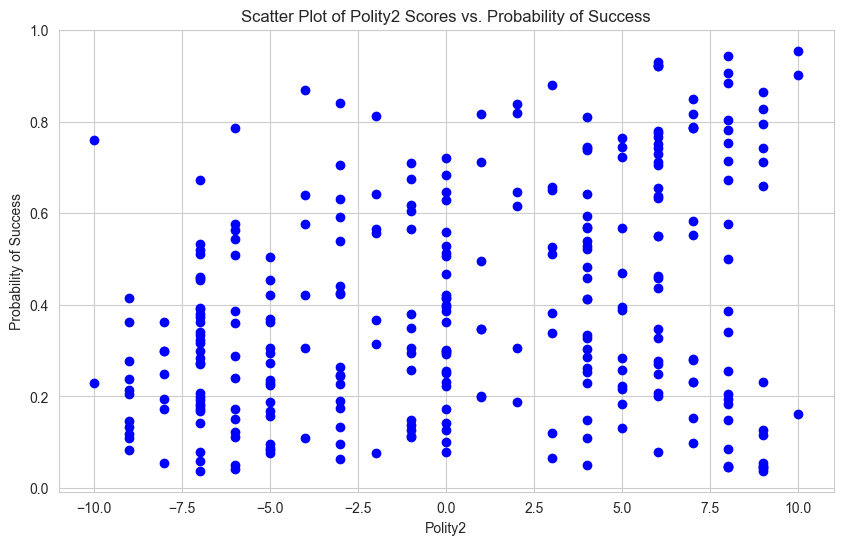

In [43]:
# Prepare the features for prediction
X = sm.add_constant(navco_data_merged[['POPULATION', 'polity2', 'NONVIOL', 'PARTICIPATION']])
# Predict the probability of success
navco_data_merged['PredictedProbability'] = model.predict(X)
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(navco_data_merged['polity2'], navco_data_merged['PredictedProbability'], color='blue')
plt.xlabel('Polity2')
plt.ylabel('Probability of Success')
plt.gca().set_axisbelow(True)
plt.title('Scatter Plot of Polity2 Scores vs. Probability of Success')
plt.grid(True)

From the scatterplot of the polity2 scores and the success rate we can see that the higher the polity2 score the higher the success rate.
 That means that the higher the polity2 score the more democratic the regime is and the more democratic the regime is the higher the probability of success.
However, this is not very clear from the scatterplot and this is evident due to the low coefficient of the polity2 score in the regression model.

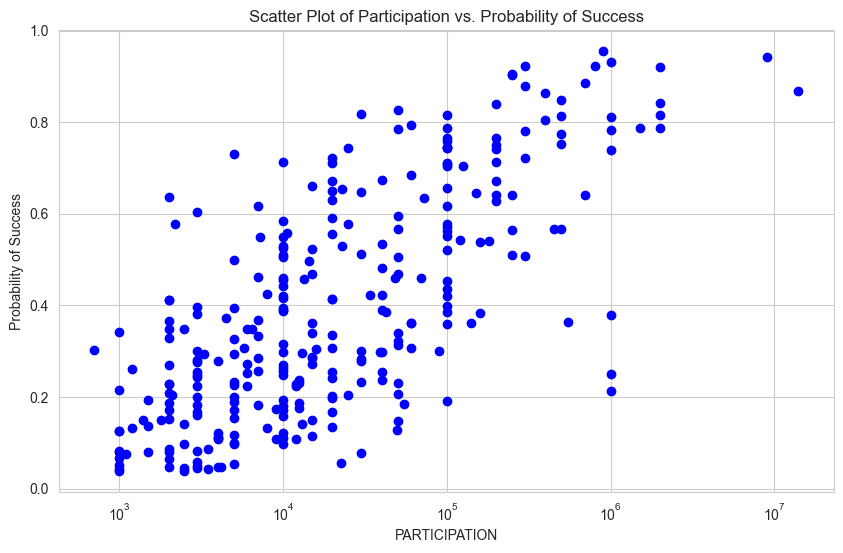

In [44]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter((navco_data_merged['PARTICIPATION']), navco_data_merged['PredictedProbability'], color='blue')
plt.xlabel('PARTICIPATION')
# Show the participation on a logarithmic scale
plt.xscale('log')
plt.ylabel('Probability of Success')
plt.title('Scatter Plot of Participation vs. Probability of Success')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

From the scatterplot of the log of participation and the success rate we can see that the higher the participation the higher the success rate (observable from the linear rate of increase from the plot), which is evident due to the high coefficient of the log of participation in the regression model.

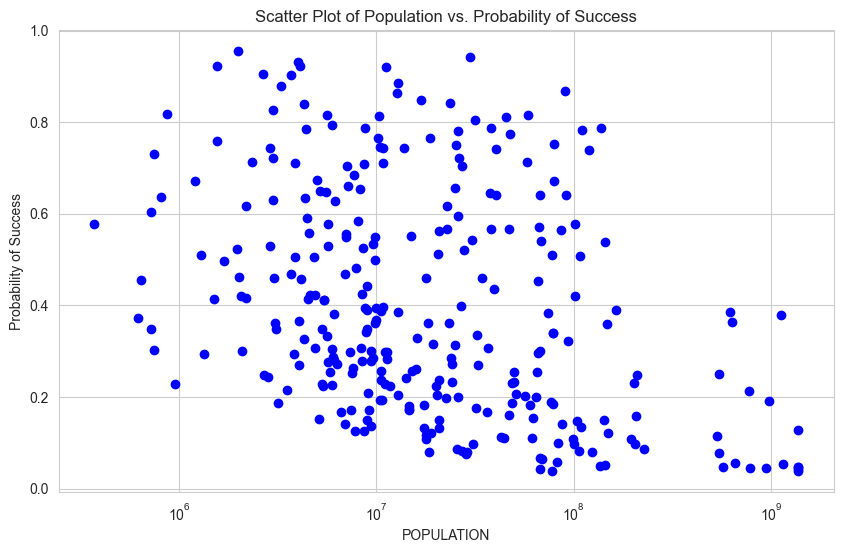

In [45]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter((navco_data_merged['POPULATION']), navco_data_merged['PredictedProbability'], color='blue')
plt.xlabel('POPULATION')
# Show the population on a logarithmic scale
plt.xscale('log')
plt.ylabel('Probability of Success')
plt.title('Scatter Plot of Population vs. Probability of Success')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

From the scatterplot of the log of population and the success rate we can see that the higher the population the lower the success rate (observable from the linear rate of decrease from the plot), which is evident due to the coefficient of the log of population in the regression model.

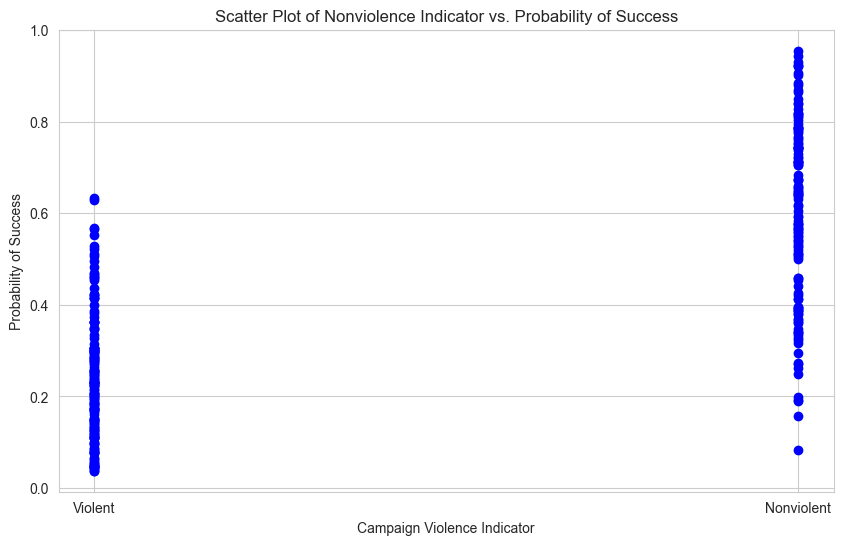

In [46]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(navco_data_merged['NONVIOL'], navco_data_merged['PredictedProbability'], color='blue')
plt.xticks([0, 1], ['Violent', 'Nonviolent'])
plt.xlabel('Campaign Violence Indicator')
plt.ylabel('Probability of Success')
plt.title('Scatter Plot of Nonviolence Indicator vs. Probability of Success')
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.show()

From the scatterplot of the nonviolence indicator and the success rate, although not easily seen,
 we can see that the nonviolent campaigns have a higher success rate than the violent campaigns, which is evident due to the high coefficient of the nonviolence indicator in the regression model.

### Having finished with our interpretation, we can now answer whether nonviolent resistance remains significant even if we control for the regime type. 

> The answer is **yes**, as the logistic regression model shows that nonviolent campaigns have higher log odds
> of success compared to violent campaigns, even when controlling for the regime type of the target.